# COMP 6934 - Assignment 4
- Professor:       Terrence Tricco
- Term:            Winter 2024
- Student Name:    **Daniel Wiredu**
- Student User:    **dbwiredu**
- Student Email:   dbwiredu@mun.ca
- Student ID:      **202286594**

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Question 1:

___

<Axes: xlabel='Hours'>

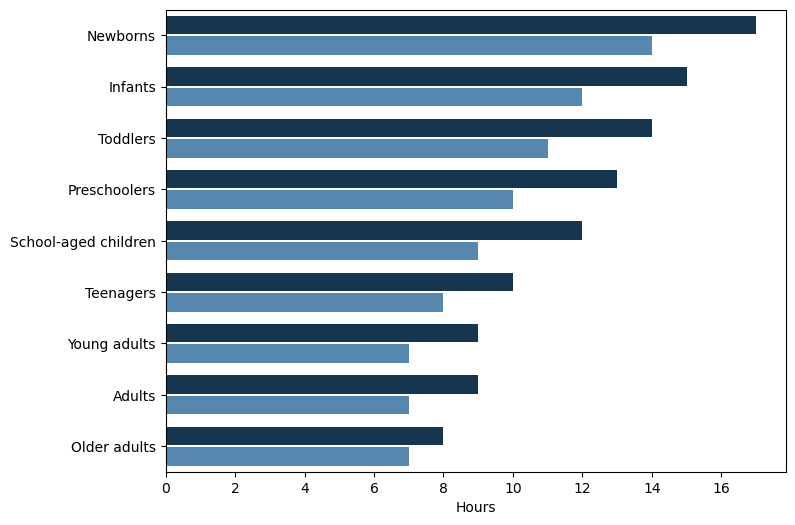

In [2]:
#load dataset
df_sleep = pd.read_csv('sleep.csv')

# Create plot objects
fig, ax = plt.subplots(figsize=(8, 6))

#get and merge required data
categories = df_sleep['Age group'].sort_index(ascending=False)
lVal = df_sleep['Recommended lower'].sort_values()
uVal = df_sleep['Recommended upper'].sort_values()
values = pd.concat([categories, uVal, lVal], axis=1).sort_index(ascending=True)

#Reshape the DataFrame
plot_data = pd.melt(values, id_vars="Age group", var_name="Limits", value_name="Hours")
plot_data.rename(columns={'Age group': ''}, inplace=True)

#Single line seaborn barplot
sns.barplot(data=plot_data, gap=0.1, legend=False, x='Hours', y='', orient='h', hue='Limits', palette=['#0c3759', '#4789be'])

## Question 2:

___

Text(0.85, 298, '2010s')

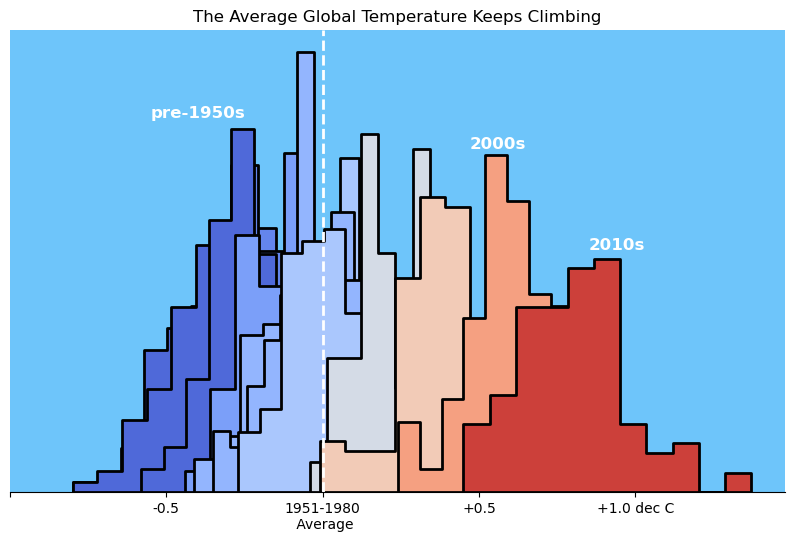

In [3]:
#load dataset
df_temps = pd.read_csv('temps.csv')

#manipulate data
dfm = pd.melt(df_temps, id_vars="Year", var_name="Month", value_name="Temp")
bin_edges = range(1879, 2020, 10)
dfm['Decade'] = pd.cut(dfm['Year'], bins=bin_edges, labels=range(1880, 2020, 10))

fig, ax = plt.subplots(figsize=(10, 6))
palette = sns.color_palette("coolwarm", 14)

#calculate mean temperature for each decade and scale it for color palette indexing
means = dfm.groupby('Decade')['Temp'].mean().reset_index()
colors = {decade: palette[int((mean_std - min(means['Temp'])) / (max(means['Temp']) - min(means['Temp'])) * (len(palette) - 1))] for decade, mean_std in zip(means['Decade'], means['Temp'])}

#plot histogram for each decade
for i, decade in enumerate(range(1880, 2020, 10)):
    dv = dfm[dfm['Decade']==decade].sort_values(by='Temp')
    sns.histplot(dv, x="Temp", element="step", zorder=i, bins=11, color=colors[decade], ec='black',lw=2, alpha=1, stat='frequency')

# Get current axis (ax)
ax = plt.gca()

# Set background color and other customizations
ax.patch.set_facecolor('#6ec5fa')    
ax.axvline(x=0, color='white', linestyle='--', linewidth=2, zorder=11)
ax.set_title('The Average Global Temperature Keeps Climbing')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.yaxis.set_ticks_position('none') 
ax.spines[['left','top','right']].set_visible(False)
ax.set_xticks(np.arange(-1, 1.5, 0.5))  
ax.set_xticklabels(['','-0.5','1951-1980\n Average','+0.5','+1.0 dec C'])
ax.set_xlabel('')
ax.text(-0.55, 460, 'pre-1950s', ha='left', color='white', fontsize=12, weight='bold')
ax.text(0.47, 422, '2000s', ha='left', color='white', fontsize=12, weight='bold')
ax.text(0.85, 298, '2010s', ha='left', color='white', fontsize=12, weight='bold')

## Question 3:

___

### Modified Alluvial Code

In [4]:
#import numpy as np
from collections import Counter, defaultdict, OrderedDict
#import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import colormaps


def plot(input_data, *args, **kwargs):
    # This function plots the alluvial diagram
    # It allows the user to use this module without seeing its internals!!!!!!!!!!!!!!!!! It's magic!!!
    # TODO: Turn this function into a static method in AlluvialTool
    at = AlluvialTool(input_data, *args, **kwargs)
    ax = at.plot(**kwargs)
    ax.axis('off')
    return ax


class AlluvialTool:
    def __init__(
            self,
            input_data=(),
            x_range=(0, 1),
            res=20,
            h_gap_frac=0.03,
            v_gap_frac=0.03,
            **kwargs):
        # TODO: Break __init__ into several smaller sub-methods that do one thing each!
        # TODO: Turn all "getters" into setters or generate methods
        # TODO: Add documentation to methods
        self.input = input_data  # Describes pairs of labels from 2 categories (e.g. "country" - "spoken language")
        self.x_range = x_range  # Diagram coordinates in x-axis
        self.res = res  # Defines the number of spline points used to draw veins
        self.h_gap_frac = h_gap_frac  # Defines the horizontal distance between matplotlib patches (relative to x_range)
        self.v_gap_frac = v_gap_frac  # Defines the vertical distance between matplotlib patches (relative to max y)
        self.vein_blueprint = self.make_vein_blueprint_arrays()
        self.input_data_dict = self.read_input()  # TODO: Consider explicitly passing input_data
        self.item_width_dict = self.get_item_width_dict()
        self.src_group, self.dst_group = self.groups = self.get_ordered_label_groups(**kwargs)
        # TODO: get h_gap and v_gap from method/s
        self.h_gap = x_range[1] * h_gap_frac
        self.v_gap = sum(
            [width for b_item_counter in self.input_data_dict.values()
             for width in b_item_counter.values()]
        ) * v_gap_frac
        self.group_widths = self.get_group_widths()
        self.item_coord_dict = self.generate_item_coordinate_dict()
        self.alluvial_fan = self.generate_alluvial_fan()
        self.item_text_len, self.width_text_len = self.get_vein_label_lengths()

    def make_vein_blueprint_arrays(self):
        y = np.array([0, 0.15, 0.5, 0.85, 1])
        x = np.linspace(self.x_range[0], self.x_range[-1], len(y))
        z = np.polyfit(x, y, 4)
        f = np.poly1d(z)

        blueprint_x_vals = np.linspace(x[0], x[-1], self.res)
        blueprint_y_vals = f(blueprint_x_vals)
        return blueprint_x_vals, blueprint_y_vals

    def get_vein_polygon_xy(self, y_range, width):
        x, y = self.vein_blueprint
        y0, yn = y_range
        scale = yn - y0
        ty = y * scale + y0
        x_new = np.concatenate([x, x[::-1], ])
        y_new = np.concatenate([ty, ty[::-1] + width, ])
        return np.array([x_new, y_new]).transpose()

    def read_input_from_list(self):
        data_table = np.array(self.input)
        data_dic = defaultdict(Counter)
        for line in data_table:
            data_dic[line[0]][line[1]] += 1
        return data_dic

    def read_input_from_dict(self):
        #data_dic = self.input
        #data_table = []
        #for x_item, y_item_counter in data_dic.items():
        #     for y_item, count in y_item_counter.items():
        #            data_table += [[x_item, y_item]] * count
        #data_table = np.array(sorted(data_table))
        #return data_table, data_dic
        return self.input

    def read_input(self):
        if type(self.input) == dict:
            return self.read_input_from_dict()
        else:
            return self.read_input_from_list()

    def get_item_width_dict(self):
        iwd = Counter()  # item_width_dict
        for src_item_label, dst_width_dict in self.input_data_dict.items():
            for dst_item_label, width in dst_width_dict.items():
                iwd[src_item_label] += width
                iwd[dst_item_label] += width
        return iwd

    def get_ordered_label_groups(self, src_label_override=None, dst_label_override=None, **kwargs):
        # TODO: Remove code duplication from creation of src, dst lists
        _ = kwargs

        src_ordered_labels = src_label_override if src_label_override else sorted(
            {src_item for src_item in self.input_data_dict}, key=lambda x: self.item_width_dict[x])

        dst_ordered_labels = dst_label_override if dst_label_override else sorted(
            {dst_item for dst_item_counter in self.input_data_dict.values() for dst_item in dst_item_counter},
            key=lambda x: self.item_width_dict[x])

        return src_ordered_labels, dst_ordered_labels

    def get_group_widths(self):
        return [self.get_group_width(group) for group in (self.src_group, self.dst_group)]

    def get_group_width(self, group):
        return sum([self.item_width_dict[item] for item in group]) + (len(group) - 1) * self.v_gap

    def generate_item_coordinate_dict(self, ):
        item_coord_dict = defaultdict(ItemCoordRecord)
        for ind, group in enumerate(self.groups):
            last_pos = (max(self.group_widths) - self.group_widths[ind]) / 2
            # TODO: Move inner for loop into a method
            for item in group:
                width = self.item_width_dict[item]
                xy = (self.x_range[ind], last_pos)
                item_coord_dict[item].set_start_state(width, xy, side=ind)
                last_pos += width + self.v_gap
        return item_coord_dict

    def generate_alluvial_vein(self, src_item, dst_item):
        # TODO: Move coordinate allocation from here to ItemCoordRecord and rename to allocator
        width = self.input_data_dict[src_item][dst_item]
        #print(width)
        src_item_coord = self.item_coord_dict[src_item].read_state_and_advance_y(width)
        dst_item_coord = self.item_coord_dict[dst_item].read_state_and_advance_y(width)
        y_range = (src_item_coord[1], dst_item_coord[1],)
        return self.get_vein_polygon_xy(y_range, width)

    def get_label_rectangles_xy(self, a_item, b_item):
        width = self.input_data_dict[a_item][b_item]
        return (
            self.generate_item_sub_rectangle(a_item, width),
            self.generate_item_sub_rectangle(b_item, width),
        )

    def generate_item_sub_rectangle(self, item, width):
        dic_entry = self.item_coord_dict[item]
        item_coord = dic_entry.read_state()
        sign = dic_entry.get_side_sign()
        return self.get_rectangle_xy(item_coord, width, sign)

    def get_rectangle_xy(self, item_coord, width, sign):
        x, y = item_coord
        rect = [[
            x + sign * 0.5 * (0.5 + xa) * self.h_gap,
            y + ya * width,
        ] for xa, ya in ((0, 1), (0, 0), (1, 0), (1, 1))]
        return np.array(rect)

    def generate_alluvial_fan(self, ):
        alluvial_fan = OrderedDict()
        #alluvial_fan = {}
        for src_item in self.src_group:
            dst_items_for_current_src_item = self.input_data_dict[src_item].keys()
            for dst_item in self.dst_group:
                if dst_item in dst_items_for_current_src_item:
                    src_label_rect, dst_label_rect = self.get_label_rectangles_xy(src_item, dst_item)
                    alluvial_fan[(src_item, dst_item)] = [
                        self.generate_alluvial_vein(src_item, dst_item),
                        src_label_rect,
                        dst_label_rect,
                    ]
        return alluvial_fan

    
    def plot(self, figsize=(10, 15), alpha=0.5, **kwargs):
        colors = self.get_color_array(**kwargs)
        fig, ax = plt.subplots(figsize=figsize)

        for ind, vein_items in enumerate(self.alluvial_fan.values()):
            src_item, dst_item = list(self.alluvial_fan.keys())[ind]
            width = self.input_data_dict[src_item][dst_item]
            patches = [Polygon(item, facecolor=colors[ind], alpha=alpha) for item in vein_items]
            patches
            for patch in patches:
                patch.set_zorder(width)
                ax.add_patch(patch)              
        self.auto_label_veins(**kwargs)
        self.label_sides(**kwargs)
        ax.autoscale()
        return ax
    
    
    def get_color_array(self, colors=None, color_side=0, rand_seed=1, cmap=None, **kwargs):
        _ = kwargs
        color_items = self.dst_group if color_side else self.src_group
        lci = len(color_items)
        if rand_seed is not None:
            np.random.seed(rand_seed)
        cmap = cmap if cmap is not None else colormaps['hsv']
        color_array = colors if colors is not None else [
            cmap(item) for ind, item in enumerate(np.random.rand(lci))]
        ind_dic = {item: ind for ind, item in enumerate(color_items)}
        polygon_colors = []
        for a_item, b_item, in self.alluvial_fan:
            item = b_item if color_side else a_item
            polygon_colors += [color_array[ind_dic[item]]]
        return np.array(polygon_colors)

    def get_vein_label_lengths(self):
        item_text_len = max([len(it) for it in self.item_width_dict], default=0)
        width_text_len = max([len(str(w)) for w in self.item_width_dict.values()], default=0)
        return item_text_len, width_text_len

    def auto_label_veins(self, fontname='Monospace', **kwargs):
        # shift = max([len(item) for item in self.item_coord_dic.keys()]) / 50
        for item, vein in self.item_coord_dict.items():
            y_width = vein.get_width()
            sign = vein.get_side_sign()
            side = int(sign + 1) // 2
            ha = 'left' if side else 'right'
            plt.text(
                vein.get_x() + 1.5 * sign * self.h_gap,
                vein.get_y() + y_width / 2,
                self.item_text(item, side, **kwargs),
                ha=ha, va='center', fontname=fontname)

    def label_sides(
            self,
            labels=None,
            label_shift=0,
            disp_width=False,
            wdisp_sep=7 * ' ',
            fontname='Arial',
            **kwargs):
        if labels is not None:
            _ = kwargs
            y = max(self.group_widths) / 2
            itl, wtl = self.item_text_len, self.width_text_len
            for side, sign in enumerate((-1, 1)):
                plt.text(
                    self.x_range[side] + sign * (
                            label_shift + itl + int(disp_width) * (len(wdisp_sep) + wtl))
                    * self.h_gap_frac,
                    y,
                    labels[side],
                    # bidi.algorithm.get_display(labels[side]),  # RTL languages
                    ha='center',
                    va='center',
                    fontname=fontname,
                    fontsize=13,
                    rotation=90 - 180 * side
                )

    def item_text(
            self, item, side,
            disp_width=False, wdisp_sep=7 * ' ', width_in=True, **kwargs):
        _ = kwargs
        f_item = item
        # f_item = bidi.algorithm.get_display(item)  # for RTL languages
        tal = '<' if f_item == item else '>'
        if not disp_width:
            ans = ('{:%s}' % tal).format(item)
        else:
            width = self.item_coord_dict[item].get_width()
            if side and width_in or (not side and not width_in):
                lc, rc, wl, wr, tl, tr = '>', tal, self.width_text_len, self.item_text_len, width, f_item,
            else:
                lc, rc, wl, wr, tl, tr = tal, '>', self.item_text_len, self.width_text_len, f_item, width,
            pat = '{:%s%d}%s{:%s%d}' % (lc, wl, wdisp_sep, rc, wr,)
            ans = pat.format(tl, tr, )
        return ans


class ItemCoordRecord:
    def __init__(self, ):
        self.width = 0
        self.xy = ()
        self.curr_xy = self.xy[:]
        self.side = -1

    def set_start_state(self, width, xy, side):
        self.width = width
        self.xy = xy
        self.curr_xy = list(self.xy[:])
        self.side = side

    def read_state_and_advance_y(self, width):
        out = self.curr_xy[:]
        self.curr_xy[1] += width
        return out

    def read_state_and_advance_x(self, width):
        out = self.curr_xy[:]
        self.curr_xy[0] += width
        return out

    def read_state(self):
        return self.curr_xy[:]

    def get_xy(self, ):
        return self.xy

    def get_x(self, ):
        return self.xy[0]

    def get_y(self, ):
        return self.xy[1]

    def get_width(self, ):
        return self.width

    def get_side_sign(self, ):
        return 1 if self.side else -1


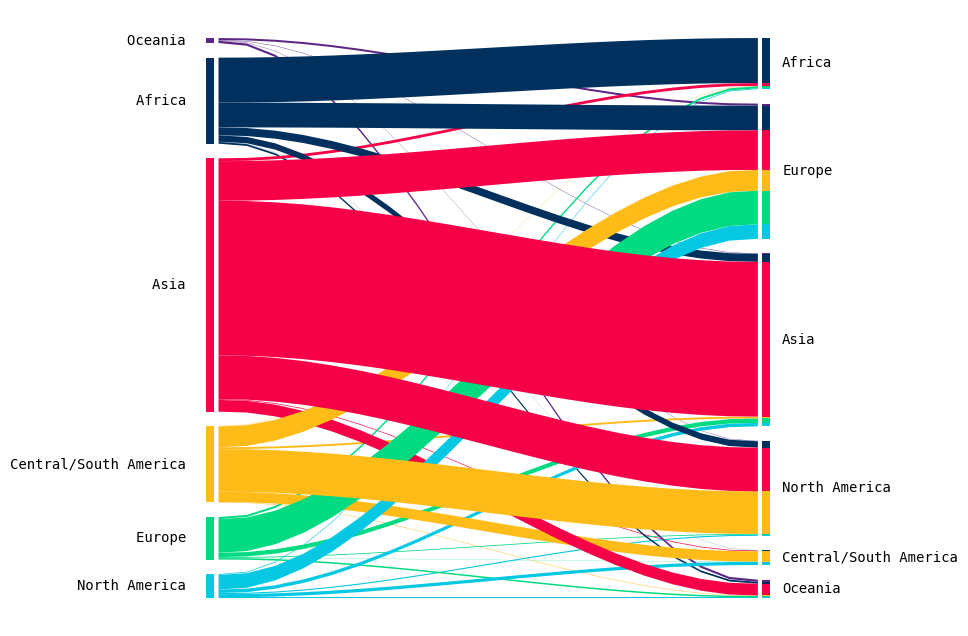

In [5]:
#load dataset
df_migration = pd.read_csv('migration.csv')

#perform data manipulation
dfm = pd.melt(df_migration, id_vars="origin", var_name="destination", value_name="NoOfPeople")
data = {str(row['origin'])+' ': {row2['destination']: row2['NoOfPeople'] for index2, row2 in dfm[dfm.origin == row['origin']].sort_index().iterrows()} for index, row in df_migration.sort_index().iterrows()} 
#print(data)

#specify color for each Region
colorSet = ['#07c8e3','#00da80','#ffbb18','#f60048','#00305d','#5c2483']

ax = plot(
    data, colors=colorSet, alpha=1, 
    src_label_override=['North America ','Europe ', 'Central/South America ','Asia ','Africa ', 'Oceania '],
    dst_label_override=['Oceania','Central/South America','North America', 'Asia','Europe','Africa',],
    )
fig = ax.get_figure()
fig.set_size_inches(8,8)
plt.show()

## References
- https://stackoverflow.com/questions/38807895/seaborn-multiple-barplots
- https://seaborn.pydata.org/generated/seaborn.barplot.html
- https://seaborn.pydata.org/generated/seaborn.histplot.html
- https://github.com/vinsburg/alluvial_diagram